# measuring radial creation distribution
Tim Tyree<br>
6.23.2023

In [1]:
from lib.my_initialization import *
import shutil
from lib import unwrap_and_center_xy_values
from scipy.signal import savgol_filter
from lib import ScatterPlotSnapshot
from lib import *

/Users/timothytyree/opt/miniconda3/envs/pyenv/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import seaborn as sns
#reset matplotlib
plt.plot([1]*4)
plt.close()
#reset matplotlib settings
import matplotlib as mpl
sns.reset_orig()
mpl.rc_file_defaults()

In [4]:
from scipy import stats
darkmode=False
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
import warnings
warnings.simplefilter("ignore", UserWarning)
# import cupy as cp
np.random.seed(42)
# cp.random.seed(42)

In [5]:
from scipy.optimize import curve_fit
from scipy.integrate import cumtrapz

# define module

In [180]:
def measure_creation_ranges(g,width,height):
    """
    Example Usage:
dict_out_lst = measure_creation_ranges(g,width,height)
    """
    #inputs: g,width,height
    #outputs: dict_out_lst
    distance_L2_pbc = get_distance_L2_pbc(width=width, height=height)
    DT=g['t'].min()
    dict_out_lst=[]
    n_series = g.groupby(by='t')['n'].min()
    t_values_birth = n_series[n_series.diff()==2.].index.values
    for tb in t_values_birth:
        d_prev = g.loc[g['t']==tb-DT]
        d_next = g.loc[g['t']==tb]
        n=n_series.loc[tb]
        #track the particles in this and the next frame only
        id_pair_lst,disp_pair_lst=find_nearest_neighbors_simple(d_prev,d_next,distance_L2_pbc)#,xy_col_lst=['x','y'],**kwargs)
        xy_values = d_next[['x','y']].values
        #select the new tips
        i_new_tips = tuple(set(range(n)).difference(id_pair_lst[1]))
        #compute the distance between them
        dist0=distance_L2_pbc(xy_values[i_new_tips[0]],xy_values[i_new_tips[1]])
        mindist=10*width
        minj=-1
        mini=-1
        #for each new tip
        for i in i_new_tips:
            xy=xy_values[i]
            #compute the distance to nearest preexisting tip
            for j in id_pair_lst[1]:
                dist=distance_L2_pbc(xy_values[i],xy_values[j])
                if mindist>dist:
                    mindist=dist
                    minj=j
                    mini=i
        #record
        dict_out = dict(mini=mini,minj=minj,dist0=dist0,mindist=mindist,n=n,tb=tb,trial_num=trial_num)
        dict_out_lst.append(dict_out)
    return dict_out_lst

# measure radial creation distribution

In [181]:
printing=True
use_save_df_to_parquet_by=True
#load fortranic tip positions
# folder=f"{nb_dir}/Data/from_wjr/positions_fk/200x200"
folder=f"{nb_dir}/Data/from_wjr/positions_lr/200x200"
# fn = 'tippos_per_c_001'
fn = 'tippos_per_001'
input_dir = os.path.join(folder,fn)
log_folder_parquet=f'{folder}/positions'
assert os.path.exists(input_dir)
if use_save_df_to_parquet_by:
    df_log=parse_fortranic_tip_pos(input_dir)
    #partition df_log into a folder of tip logs
    save_df_to_parquet_by(df_log,log_folder_parquet,by='trial_num',compression='snappy',index=None)
    print(f"saved to spiral tip positions to {log_folder_parquet=}")
    #determine width and height of the computational domain input the discretization
    width,height=df_log.describe().loc['max'][['x','y']].values.T
    del df_log
else:
    width=200
    height=200

saved to spiral tip positions to log_folder_parquet='/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/positions'


In [182]:
for fn in os.listdir(log_folder_parquet):
    pass
trial_num = eval(fn.split('=')[1])
# load tip position data
g=load_parquet_by_trial_num(trial_num=trial_num,folder_parquet=log_folder_parquet)
DT=g['t'].min()
if printing:
#     print(df_log.describe().loc[['min','max']][['x','y']])
    print(f"{width=}, {height=}, {DT=}")

width=200.0, height=200.0, DT=1.0


In [183]:
distance_L2_pbc = get_distance_L2_pbc(width=width, height=height)
DT=g['t'].min()
dict_out_lst=[]
n_series = g.groupby(by='t')['n'].min()
t_values_birth = n_series[n_series.diff()==2.].index.values
for tb in t_values_birth:
    pass
d_prev = g.loc[g['t']==tb-DT]
d_next = g.loc[g['t']==tb]
id_pair_lst,disp_pair_lst=find_nearest_neighbors_simple(d_prev,d_next,distance_L2_pbc)#,xy_col_lst=['x','y'],**kwargs)        

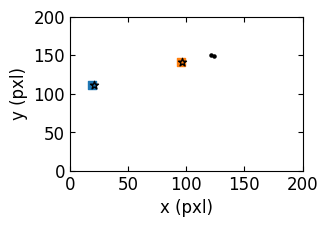

In [184]:
#check that local tracking is working
fig,ax=plt.subplots(figsize=(3,2))
d_next.plot(kind='scatter',x='x',y='y',marker='.',ax=ax,color='k')

for ii,(i1,i2) in enumerate(id_pair_lst):
    ax.scatter(x=d_prev['x'].values[i1],
                y=d_prev['y'].values[i1],
                c=f'C{ii}',marker='s')
    ax.scatter(x=d_next['x'].values[i2],
                y=d_next['y'].values[i2],
                c=f'C{ii}',marker='*',edgecolor='k')
# format_plot
ax.axis([0,width,0,height])
format_plot(xlabel='x (pxl)',ylabel='y (pxl)',fontsize=12,ax=ax)
ax.tick_params(top=True, right=True,direction='in',which='both')
plt.show()

In [185]:
def routine(task):
    log_folder_parquet,trial_num,width,height=task
    g=load_parquet_by_trial_num(trial_num=trial_num,folder_parquet=log_folder_parquet)
    dict_out_lst = measure_creation_ranges(g,width,height)
    return dict_out_lst

In [186]:
#repeat for a larger number of tips
task_lst=[]
for fn in os.listdir(log_folder_parquet):
    trial_num = eval(fn.split('=')[1])
    task = log_folder_parquet,trial_num,width,height
    task_lst.append(task)
print(f"added {len(task_lst)} tasks to task_lst")

ncores = os.cpu_count()-1
print(f"running {len(task_lst)} tasks over {ncores} cpu cores...")
retval_lst = eval_routine_multiprocess(routine, task_lst, ncores)

added 641 tasks to task_lst
running 641 tasks over 7 cpu cores...


In [187]:
lst=[]
for retval in retval_lst:
    lst.extend(retval)
df = pd.DataFrame(lst)
del lst
df.shape

(14204, 7)

In [188]:
#save to .csv
rcd_dir= os.path.join(folder,'radial_creation_distribution.csv')
df.to_csv(rcd_dir,index=False)

# visualize radial creation distribution

In [189]:
DX=0.025 #cm/pxl

In [190]:
Rc_values = DX*df['mindist'].values
# Rc_values = DX*df[df['n']==4]['mindist'].values
# Rc_values = DX*df[df['n']>=4]['mindist'].values
# Rc_values = DX*df[df['n']==10]['mindist'].values

No handles with labels found to put in legend.


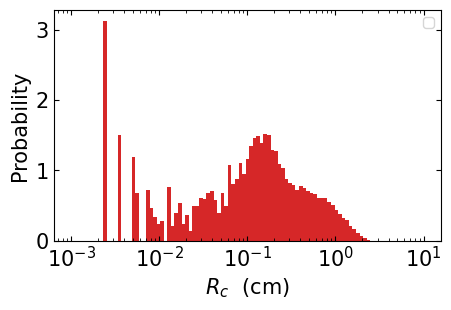

In [213]:
#visualize the radial creation distribution
#check that local tracking is working
fig,ax=plt.subplots(figsize=(5,3))
                
# bins=np.arange(0,5,0.1)
# bins=np.arange(0.3,5,0.1)
bins=np.arange(0.3,5,0.05)
bins=np.logspace(-3,1,100)
# bins=np.logspace(-2,1,100)
# bins=np.logspace(-0.43,2,100)
rv=ax.hist(Rc_values,bins=bins,density=True,color='C3')
    
# format_plot
format_plot(xlabel=r'$R_c$  (cm)',ylabel='Probability',fontsize=15,ax=ax)
# format_plot(xlabel=r'$R_c(N>2)$  (cm)',ylabel='Probability',fontsize=15,ax=ax)
# format_plot(xlabel=r'$R_c(N=2\rightarrow 4)$  (cm)',ylabel='Probability',fontsize=15,ax=ax)
# format_plot(xlabel=r'$R_c(N=4\rightarrow 6)$  (cm)',ylabel='Probability',fontsize=15,ax=ax)
# format_plot(xlabel=r'$R_c(N=6\rightarrow 8)$  (cm)',ylabel='Probability',fontsize=15,ax=ax)
# format_plot(xlabel=r'$R_c(N=8\rightarrow 10)$  (cm)',ylabel='Probability',fontsize=15,ax=ax)
ax.tick_params(top=True, right=True,direction='in',which='both')
ax.set_xscale('log')
# ax.set_yscale('log')
#TODO: show fit to Gamma distribution 
#HINT: # GammaDistribution[5.85544,0.159078]



# # ExtremeValueDistribution[0.751593,0.308412]
# c=0.751593;d=0.308412
# x = np.linspace(scipy.stats.genextreme.ppf(0.01, c,d),
#                 scipy.stats.genextreme.ppf(0.99, c,d), 100)
# ax.plot(x, scipy.stats.genextreme.pdf(x, c,d),'k-', lw=2, alpha=0.6, label='genextreme pdf')
ax.legend()
plt.show()

In [204]:
# scipy.stats.genextreme.ppf

In [205]:
#DONE: look for the dependence on n
#TODO: quantify the radial creation distribution
#HINT: use Mathematica

In [206]:
np.min(bins)

0.37153522909717257

In [207]:
# print(list(Rc_values[Rc_values>0.37][:1000]))

In [208]:
# # DONE: measure R_c_bar for the FK model
# R_c_bar=0.7028562 # cm
# R_c_rms=0.8462717 # cm
# TODO: measure R_c_bar for the LR model
# TODO: dev creation model using R_c_bar


In [209]:
# measure R_c_bar
R_c_bar = np.mean(Rc_values)
R_c_rms = np.sqrt(np.mean(Rc_values ** 2))
print(f"{R_c_bar=:.7f} # cm")
print(f"{R_c_rms=:.7f} # cm")

R_c_bar=0.6666909 # cm
R_c_rms=0.8378328 # cm


In [210]:
#  = bootstrap_95CI_Delta_mean(x, num_samples=1000)

In [211]:
meanx,Delta_meanx,num_obs,p_normal=comp_mean_bootstrap_uncertainty(Rc_values)
printing=True
if printing:
    print(f"mean: {meanx:.4f} +/- {Delta_meanx:.4f} (N={num_obs}, {p_normal=:.4f})")


mean: 0.6667 +/- 0.0082 (N=14204, p_normal=0.8265)


# TODO(in new .ipynb): dev creation model based on this algorithm
1. produce level set of distance, $R_c$ as R_c_bar, from the set of all tips
1. randomly select a contour from the resulting list of lists of segments
1. randomly choose a number uniformly on the interval 0 to 1
1. place new pair of tips on the linear interpolant of that contour (HINT: use the segment that connects the nearest two points)
1. space the new pair of tips $R_i$ apart oriented at a random angle, $\phi_i$
1. time step forward using a repulsive force between the particles
    - Q: in time it follows a gamma distribution. what is the repulsive force versus distance?